(page:how-to-zarr)=
# Storing data loaded with xapres
An advantage of storing ApRES data in xarray datasets is that they are easily written to and read from either local disk or cloud storage. xarray can read and write a large number of storage formats, but we will focus on zarr stores because they are a particularly efficient way of storing data in the cloud. We will focus on the simple case when the total size of the dataset is small enough to fit into memory.

## Writing an xarray dataset to a local zarr store
First let's generate a small dataset from a dat file with multiple bursts. 

In [17]:
import sys
sys.path.append("../../../xapres") 
import xapres as xa

fd_unattended = xa.load.from_dats()
data_unattended = fd_unattended.load_all(directory='../../data/sample/multi-burst-dat-file', bursts_to_process=range(0,1))
data_unattended

100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


<xarray.Dataset>
Dimensions:          (time: 1, chirp_time: 40001, chirp_num: 20,
                      attenuator_setting_pair: 2, profile_range: 39999)
Coordinates:
  * time             (time) datetime64[ns] 2022-05-22T19:40:20
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
    filename         (time) <U62 '../../data/sample/multi-burst-dat-file/DATA...
    burst_number     (time) int64 0
    AFGain           (attenuator_setting_pair) int64 -14 -14
    attenuator       (attenuator_setting_pair) float64 10.0 20.0
    orientation      (time) <U7 'unknown'
  * profile_range    (profile_range) float64 0.0 0.2103 ... 8.411e+03 8.411e+03
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    latitude         (time) float64 69.22
    longitude        (time) float64 -51.12
    battery_voltage  (time) float64 12.33
    temperature_1    (time) float64 4.383
    temperature_2    (time) float64 5.195
    profile          (time, chirp_num, attenuator_setting_pair, profile_range) complex128 ...
Attributes:
    constants:   {'c': 300000000.0, 'K': 200000000.0, 'f_1': 200000000, 'f_2'...
    processing:  Created on 2025-01-06 15:20:45.949757

Once the ApRES data is loaded into memory in an xarray dataset it is straightforward to write it to a zarr store. 

In [18]:
!rm -rf data/temp_zarr
data_unattended.to_zarr('data/temp_zarr/multi-burst.zarr');

## Reading from a local zarr store
This can now be reloaded using a function supplied in `xapres.load` called `load_zarr` (this is just a wrapper around `xarray.open_dataset`).

In [19]:
reloaded = xa.load.load_zarr('data/temp_zarr/multi-burst.zarr')

We can double check that we got back exactly what we wrote to disk as follows

In [20]:
print((data_unattended.profile.values == reloaded.profile.values).all())
print((data_unattended.chirp.values == reloaded.chirp.values).all())

True
True


## Writing to a cloud zarr store
Writing to a cloud zarr store is also straightforward. To actually do this you will need a token to a cloud storage service such as AWS S3, Google Cloud Storage, or Azure Blob Storage. Tokens are secret and you can generated one by following the instructions for the cloud storage service you are using. We generally use google cloud storage. We won't reveal our token here, but you can see how we use it in the code below. `token.json` is a file generated using the google cloud services console.
```python
import json
import fsspec

with open('token.json') as token_file:
    token = json.load(token_file)

mapper = fsspec.get_mapper("gs://ldeo-glaciology/apres/thwaites/continuous/zarrs/temp1.zarr", mode='w', token=token)
data_unattended.to_zarr(mapper)
```

## Reading from cloud storage
Again using `xa.load.load_zarr` we can read the data written with the above cell as follows:

In [ ]:
from_zarr = xa.load.load_zarr("gs://ldeo-glaciology/apres/thwaites/demo/data_unattended_2.zarr") 

This 'lazily' loads the data, meaning that rather than loading the entire dataset into memory, it just loads the structure and location of the data. The arrays of values in the data variables are dask arrays, rather than numpy arrays. We can see this as follows:

In [21]:
from_zarr.profile

<xarray.DataArray 'profile' (time: 1, chirp_num: 20,
                             attenuator_setting_pair: 2, profile_range: 39999)>
array([[[[-1.38408785e-03+0.00000000e+00j,
           2.91118930e-04-1.40291904e-03j,
           1.47675916e-03+4.42763256e-04j, ...,
           5.65708103e-06+4.70534751e-06j,
          -5.14021868e-06+3.47754984e-06j,
          -5.54073561e-07-4.40486242e-06j],
         [-4.69493328e-04+0.00000000e+00j,
          -7.65027494e-06-4.18738932e-04j,
           2.92148672e-04-5.60861109e-06j, ...,
          -6.67954088e-07+7.81400572e-07j,
          -8.58339034e-07-1.50840176e-07j,
          -2.21426574e-07-8.15835973e-07j]],

        [[-5.47729541e-04+0.00000000e+00j,
           2.28743444e-04-6.09507831e-04j,
           7.95014645e-04+3.16940670e-04j, ...,
          -1.81472588e-06+1.78958042e-06j,
          -3.98805136e-06-2.80366373e-06j,
           2.68410270e-06-4.50968832e-06j],
         [-4.09893228e-04+0.00000000e+00j,
...
           2.32543783e-06-2.06837635e-06j],
         [-3.40366092e-04+0.00000000e+00j,
          -5.88924897e-06-3.03043013e-04j,
           2.09592224e-04-3.84978035e-06j, ...,
          -8.12553225e-07+2.06089872e-07j,
           3.96685353e-07-8.06144456e-07j,
           4.66289858e-07+7.04227949e-07j]],

        [[-2.08909252e-04+0.00000000e+00j,
           1.70289841e-04-2.50856148e-04j,
           3.80075475e-04+2.18418618e-04j, ...,
          -5.18918954e-06+3.94991042e-06j,
          -2.82274691e-06-4.14051282e-06j,
           2.15293300e-06-1.59746002e-06j],
         [-3.39915860e-04+0.00000000e+00j,
          -5.15234776e-06-3.03140758e-04j,
           2.11089424e-04-2.83223173e-06j, ...,
           5.25537109e-07+3.91009317e-07j,
          -7.64830931e-07+4.99017112e-07j,
          -1.60192219e-07-8.35746342e-07j]]]])
Coordinates:
    AFGain         (attenuator_setting_pair) int64 -14 -14
    attenuator     (attenuator_setting_pair) float64 10.0 20.0
    burst_number   (time) int64 0
  * chirp_num      (chirp_num) int64 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
    filename       (time) <U62 '../../data/sample/multi-burst-dat-file/DATA20...
    orientation    (time) <U7 'unknown'
  * profile_range  (profile_range) float64 0.0 0.2103 ... 8.411e+03 8.411e+03
  * time           (time) datetime64[ns] 2022-05-22T19:40:20
Dimensions without coordinates: attenuator_setting_pair
Attributes:
    constants:    {'B': 200000000, 'K': 200000000.0, 'T': 1, 'c': 300000000.0...
    description:  complex profile computed from the fourier transform of the ...
    long_name:    profile
    units:        -

Instead of displaying the values of `from_zarr.profile`, the cell above displays a graphic representation of the structure of the data.

To load the data into memory we can use the `load` method as follows:

In [23]:
from_zarr.profile.load()

<xarray.DataArray 'profile' (time: 1, chirp_num: 20,
                             attenuator_setting_pair: 2, profile_range: 39999)>
array([[[[-1.38408785e-03+0.00000000e+00j,
           2.91118930e-04-1.40291904e-03j,
           1.47675916e-03+4.42763256e-04j, ...,
           5.65708103e-06+4.70534751e-06j,
          -5.14021868e-06+3.47754984e-06j,
          -5.54073561e-07-4.40486242e-06j],
         [-4.69493328e-04+0.00000000e+00j,
          -7.65027494e-06-4.18738932e-04j,
           2.92148672e-04-5.60861109e-06j, ...,
          -6.67954088e-07+7.81400572e-07j,
          -8.58339034e-07-1.50840176e-07j,
          -2.21426574e-07-8.15835973e-07j]],

        [[-5.47729541e-04+0.00000000e+00j,
           2.28743444e-04-6.09507831e-04j,
           7.95014645e-04+3.16940670e-04j, ...,
          -1.81472588e-06+1.78958042e-06j,
          -3.98805136e-06-2.80366373e-06j,
           2.68410270e-06-4.50968832e-06j],
         [-4.09893228e-04+0.00000000e+00j,
...
           2.32543783e-06-2.06837635e-06j],
         [-3.40366092e-04+0.00000000e+00j,
          -5.88924897e-06-3.03043013e-04j,
           2.09592224e-04-3.84978035e-06j, ...,
          -8.12553225e-07+2.06089872e-07j,
           3.96685353e-07-8.06144456e-07j,
           4.66289858e-07+7.04227949e-07j]],

        [[-2.08909252e-04+0.00000000e+00j,
           1.70289841e-04-2.50856148e-04j,
           3.80075475e-04+2.18418618e-04j, ...,
          -5.18918954e-06+3.94991042e-06j,
          -2.82274691e-06-4.14051282e-06j,
           2.15293300e-06-1.59746002e-06j],
         [-3.39915860e-04+0.00000000e+00j,
          -5.15234776e-06-3.03140758e-04j,
           2.11089424e-04-2.83223173e-06j, ...,
           5.25537109e-07+3.91009317e-07j,
          -7.64830931e-07+4.99017112e-07j,
          -1.60192219e-07-8.35746342e-07j]]]])
Coordinates:
    AFGain         (attenuator_setting_pair) int64 -14 -14
    attenuator     (attenuator_setting_pair) float64 10.0 20.0
    burst_number   (time) int64 0
  * chirp_num      (chirp_num) int64 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
    filename       (time) <U62 '../../data/sample/multi-burst-dat-file/DATA20...
    orientation    (time) <U7 'unknown'
  * profile_range  (profile_range) float64 0.0 0.2103 ... 8.411e+03 8.411e+03
  * time           (time) datetime64[ns] 2022-05-22T19:40:20
Dimensions without coordinates: attenuator_setting_pair
Attributes:
    constants:    {'B': 200000000, 'K': 200000000.0, 'T': 1, 'c': 300000000.0...
    description:  complex profile computed from the fourier transform of the ...
    long_name:    profile
    units:        -

Lazy loading is very useful when the dataset is too large to load into memory at one time, as it allows you to process the data in chunks. [This](https://book.cryointhecloud.com/tutorials/ARCOdata_writingZarrs.html) is a tutorial that discusses a challenging case when an ApRES dataset was very large and required careful consideration of the size of the chunks to avoid memory issues. 

## Very large datasets
Now let's lazily load a very large dataset. The data were collected in unattended mode in the ablation zone of the Greenland Ice Sheet by a team led by Meredith Nettles (Lamont-Doherty Earth Observatory, LDEO) and Laura Stevens (University of Oxford), including George Lu (LDEO), Stacy Larochelle (LDEO), Marianne Okal (Earthscope), Kristin Arnold (IRIS Alpine), and Josh Rines (Stanford University). The project was funded by the US National Science Foundation (project number: 2003464). Three ApRES units were positioned near several supraglacial lakes that periodically drain to the bed of the ice sheet. The units collected a burst every 15 minutes for up to 18 months. 

In [24]:
from_zarr_large = xa.load.load_zarr() 
from_zarr_large

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 11723,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>

This dataset contains 1173 bursts of 20 chirps each. The total size of the dataset is 

In [26]:
print(f"{from_zarr_large.nbytes / 1e9} GB")

202.513838596 GB


This is much too large to load into memory, but loading it lazily allows us to extract a small portion of the data for analysis. This would be very difficult if we were dealing with 100's of individual dat files instead. 

For example, let's extract a profile from near the middle fo the dataset and plot it. 

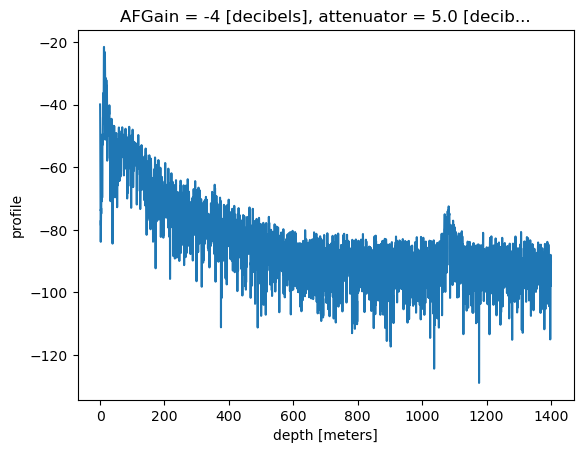

In [36]:
from_zarr_large.profile.isel(time = 6000, chirp_num = 10, attenuator_setting_pair = 0).dB().plot();

## Summary
It is straightforward to write ApRES data loaded with xapres to zarr stores, either locally or in the cloud using xarrays `.to_zarr` function. 

The xapres function `xa.load.load_zarr` can be used to reload the data back into your workspace. Initially this loads the data lazily. To load the data into memory you can call `.load()` on the dataset.

A great advantage of storing ApRES data in zarr stores rather than hundred or thousands of dat files is that it can be lazily loaded and processed efficiently in the cloud. 